# Char RNN

In [1]:
import tensorflow as tf
import NLP_Utils as nlp
import time
import numpy as np

## Hyperparams

In [2]:
#Data
filename = 'tiny_shakespeare.txt'
'''
num_features: 1 => For dense representation
num_features: vocabulary size => For One-Hot representation
'''
num_features = 1 

#Cell
state_size = 200 #Default: 200 / Test: 4

#Batches & Vocab
batch_size = 64 #Default: 64 / Test: 5 or 1
seq_length = 50 #Default: 50 / Test: 3
overlap = 25 #Default 25 / Test: 3
vocab_strategy = 'all' 

#Test
test_size = 300 #Default: 300 / Test: 25

## Read Data & Manage Batches

In [3]:
batchManager = nlp.BatchManager()
batchManager.set_params(filename,batch_size,seq_length,overlap,vocab_strategy,mode='dense')
batchManager.get_params()

num_batches = batchManager._num_batches
vocab_size = batchManager._vocab_size

@params:
[filename : "tiny_shakespeare.txt"]
[text : "First Citi"]
[text_size : 1115394]
[vocab : ['v', '&', 's', 'e', '?']]
[vocab_size : 65]
[mode : dense]
[batch_size : 64]
[seq_length : 50]
[overlap : 25]
[num_batches : 697]


In [4]:
batchManager.stats()

The corpus has 1115394 characters
Configuration:
[batch_size : 64]
[seq_length : 50]
[overlap : 25]

The current configuration gives us 697 batches of 64 observations each one looking 50 steps in the past and overlapping 25 steps


## Placeholders

seq placeholder has [None,None,num_features] dimensions because we want to use the same placeholder for train and for test.

So, for example:<br>
In train we may want: seq = [64,50,num_features]<br>
In test we may want: seq = [1,1,num_features]

That's why we have to set the dimensions as 'None'

In [5]:
seq = tf.placeholder(dtype=tf.float32,shape=[None,None,num_features],name='seq') #[Batch_size x seq_length x num_features]
seq_labels = tf.placeholder(dtype=tf.int32,shape=[None,None,num_features],name='seq_labels') #[Batch_size x seq_length]

temperature = tf.placeholder(tf.float32)

## Create RNN cell

In [6]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

'''
batch_size : seq.get_shape()[0] instead of 'batch_size' 
in order to work with variable seq length, this is, for testing char by char
'''
zero_state = cell.zero_state(batch_size=tf.shape(seq)[0],dtype=tf.float32) 


in_state = tf.placeholder_with_default(input=zero_state,shape=[None,state_size])

In [7]:
output, out_state = tf.nn.dynamic_rnn(cell=cell,inputs=seq,initial_state=in_state)

In [8]:
output

<tf.Tensor 'rnn/transpose:0' shape=(?, ?, 200) dtype=float32>

## Create model

In [9]:
seq_labels_sparse = tf.reshape(seq_labels,shape=[tf.shape(seq_labels)[0],tf.shape(seq_labels)[1]])

In [10]:
logits = tf.contrib.layers.fully_connected(inputs=output,num_outputs=vocab_size,activation_fn=None)

loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=seq_labels_sparse))

sample = tf.multinomial(logits=logits[:,-1],num_samples=1)[:,0]

In [11]:
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

## Train

In [12]:
num_epochs = 10

display_freq = num_batches//10

loss_list = list()
av_loss_list = list()

step = 0

last_epoch = -1

with tf.Session() as sess:
    start = time.time()
    tf.global_variables_initializer().run()
    
    for batchX,batchY,epoch in batchManager.generate_batches_rnn(num_epochs=num_epochs):

        
        if(last_epoch != epoch):
            print('Epoch %d:' % epoch)
            last_epoch = epoch
            
        
        _loss,_ = sess.run([loss,optimizer],{seq:batchX,seq_labels:batchY})
        
        loss_list.append(_loss)
        
        if(step % display_freq == 0):            
            if len(loss_list)>1: av_loss_list.append(np.average(a=loss_list[-display_freq]))
            
            print('At step %d:%d - Loss: %.2f - Elapsed time: %s' %(epoch,step,_loss,(time.time()-start)))
            
            ###TEST###
            sentence = 'A'
            state = None
            for _ in range(test_size):
                batch = np.array([batchManager.vocab_encode(sentence[-1])]) #Last character in sentence
                batch = batch.reshape(batch.shape[0],batch.shape[1],num_features)

                feed = {seq : batch}
                
                if state is not None: #First is none and must be None
                    feed.update({in_state:state})
                
                index,state = sess.run([sample,out_state],feed)
                sentence += batchManager.vocab_decode(index)
            print(sentence,'\n')
            ##########
            start = time.time()
            
        step += 1
            
            
        
print('Train finished')

Epoch 0:
At step 0:0 - Loss: 14625.23 - Elapsed time: 14.314077377319336
AYED:imOt&VO.FhQAe HaSHESaZAhadAyuu,gmvyd&gUEnuHRhFHFXvoO-dXhvXri-gddo:GBooIpFyILHMt3Ql?bRFuAi HAOaHa&Wv!tIMH
bZ co?o-svaHzI& vR!Fih
L;?Dd:BdFDZsSyBPaODaaDSuBi;DZiRuqio
hJvScaR.d
FtdHIpHaI mX-YIyEvFPFySOe
bpOR I3vOB--S-MAaYOgdaSMh-I,:aZtJHEiRhEHSuSH:QSiy&A,moOgoU:Q:OXUDBS:RAv'ddyoAaOpIA
IDHe.U
JoFME, 

At step 0:69 - Loss: 9873.03 - Elapsed time: 8.77986192703247
Aee  oue pnots aovhevsS syortcrcc  ee,eNnm ahepo
anmorsYne  m aorheraa,mN: gaaO,
ce yh  aTcna:cs atl mRensOha
lsy eetLs
nhI dot ryo
I  'heeON
erprtmo ie 
e thttntEpt saogeaeenm  nsdaA eo yfm?, fU;,  eaoISitndomh
WisirieftpevL e thylNs:iys ye .niev
Ces:nbuvi sosl niatet g-rdlr pa aCdwi ilst
Ml  as st  

At step 0:138 - Loss: 10586.44 - Elapsed time: 8.883979558944702
AIc:h  ren ys QyoeH, ao
rv wu:eI b a a yl COpue gedes?e- pae
ns m ae  eakm Ci mrne inmhcso sestt
 ho m e,
 s, vtSnnruuErgetoRtd RBdaeh e om le,
 wtdtth wn ltyeAlAW:o'TIl:i
irSonfuh  iskoittD:,

A.hgqe tose,Are got well whmsnresd
yerpird.s yasrure layreya hea

Vrsrl
 hearer tayer mhun vueet

IiSALUD::
Ai dert
Ann houh,'of,:at
Frdmet

GARRDR
Nni:E Eo hudih tingyer hom,iyil yodg ah mo ke id uo stet ai the c
lraAcst
tre lay,hea deadooer?,
Aetr ahe tlm wes
 yreiu,

LArAIY  bthwc

 d thetche deto 

At step 2:1587 - Loss: 8374.05 - Elapsed time: 9.166295766830444
As wuth ont wnagce
 uik f,vnmhewbt nomNounHnnsos tiks

ILITINHn
Tnl Mn baee  oscn,:om cill trane ilrsy.
,GeW gywbsp

As, mlne  orede rour saet rese wear ehordr:a
illr
IIA:e,
TgtsilaFR
:ou mittlyrh to,,Toor near firdl Hf,Hhytraimb?i:e; wotae  mTn sor
  fomeeius  elle thep doa tiknblTIyh.resreltunAsl-n 

At step 2:1656 - Loss: 7905.26 - Elapsed time: 9.069186925888062
AoouE::
MINl:iNlI: I ral Sit doT

- Runt
tI'KiBA
RKDaBif sfis pammeneet?s: wome gofent
eotE:

 tusllf oaor.
 wome of weagt timin siuldisry
Snanetryndla tlfrI od iave neankes,
Fne th cefso bn ifdn ics:,Khe,rde l rinbs the nave fare
Ain gawre,nwe
 ue ge-sios mooe 

At step 4:3105 - Loss: 7963.92 - Elapsed time: 5.621314287185669
Aem
est aomoyuret am t'th who the face I so
,Mmp a ahkung forisei ta thenca a btpers

oEwEUOINCOI kow dinh aris, gaao buth ae insmrich chycl,
Te fave bar you,t'ne ahis.

GUNEETROI itr! Rrow hast of tnseatm
L clyu'nst
Momynwor's ayrtr bsllasr oet uoteo, ti ble t
etre shems,sfh

h bast;

HRNROI:
Alse
  

At step 4:3174 - Loss: 7341.62 - Elapsed time: 9.143269300460815
AsOAu ir eecne.
And bhith bord ayeed thencl
C weremAoon-ngt
ind hea;her wint aanwhetse
D ahe ne qasm osens, that be qirDood hayptred ahan tmty;sthdtiny, Wigg keart gollNbtr or a ontrh bcti goee,d? hetnkithingbdg hainf woll thou this dos tenten, aa iit oiur hearucrd wasotdcer me dofe.

FFRGLAR:
Anf hi 

At step 4:3243 - Loss: 7572.74 - Elapsed time: 9.036556243896484
Aa
W:igdedce hniles!f mimeQ-s cith swnd'e, spots womenh.rdoo, host to bnyunete
ing hneare cita hrom to his lore :apor'se beorce 'ntraint
ie
.Idtr:.e, tre wims, she ie not corkeasta cpytr that qand.

At step 6:4692 - Loss: 7448.01 - Elapsed time: 4.65823221206665
An'dt of you this,rer;
ODUetS ofu

LAONROOLOOCS:
S
velf buokt yngtigk; chom ha hol: rai ceen sepukid.c

PAMILLMS:
For seef
esdc

CENiMAES:
Now mape me
 hour I hearg. yeepher-. per yourver tnd to ,y and to nit. feva uut call to ty ingvedh of hetr ahiye towles ey fverenofeenstlnh h'm rinhee al

SoUAEMM 

At step 6:4761 - Loss: 6953.52 - Elapsed time: 5.356017112731934
A
I will a?ltiNd mae Dope to,t moll leowdcooo kar womyael
Wull Inoun.osr forgabgsei cnywngare
y antither tune the pimher; mo liwhr,
es ahat yite
The no sact rimh and me wome, inoouk,lUro tuch hing me pfape

DUCECIO:
OorC
: Oist ae t lithl hadg gow kou. gome on me to daur;
Door, gecvel mfem bith are,  

At step 6:4830 - Loss: 7176.51 - Elapsed time: 8.713788270950317
Ais I kuthings of staix.
la rass ony ver.ise, ahy shei r thy nl
silld am t ahe hame harke folp hirt to tistsur's m fith mi huced,er ro I're usen we auull we bome game,
To thou a beaoss'not
 in saric

Ast to hit of Ef this seatin'r I and pic Iitl Tnd, mustouny ao the eoved vincestrer;
Aon ahwt!OSetf this'tI ,e.e,dont

HENIOOAATE!Chy now suspe,The hood repeew
Hs mmdareedf l bslp aimh of gentle oe stskenl,:er she waood'r me you hart sir word,
That chowh ahy lure that.
And Aoul! withoth, got, of mend 

Epoch 9:
At step 9:6279 - Loss: 7244.11 - Elapsed time: 13.580254554748535
ARnt in yintu
;h
tist it int vwsarh.

ANTNAND:
Ny aa emdeccer ost our wate,a
As anemtest Cleat,
Aernt tnd you aheyre cousll be ue silf stdulsbia of you men owr anctest y's mmye honever figgs stre sir.

SEKhAS
So aallly-ul'tndruc aast'sta

fAlNC
:
Shat lawtlssies:is rugg;be
The forvt ticp hetvide teag 

At step 9:6348 - Loss: 6845.54 - Elapsed time: 8.591651439666748
Ak
d
Fhec is hrown mast gonthause

SUUTUS:
Allech
With ylo prown
 and you,
And
ao hest yart oor:
Mor,Hgga and IitttS you?

SlRILA:
Hore heel.on that and herve flr he destenof ongmink goose
That to do you wan tris befirs, with atgmbnn elp
ise, on gownh


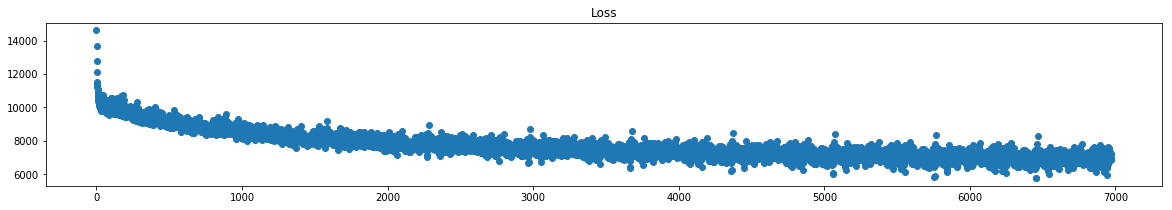

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,3))
plt.title('Loss')
plt.scatter(x=range(len(loss_list)),y=loss_list)
plt.show()

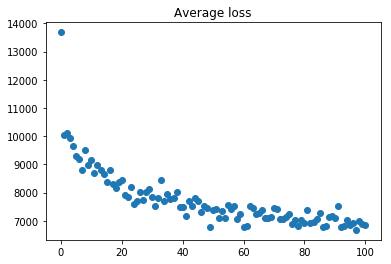

In [14]:
plt.title('Average loss')
plt.scatter(x=range(len(av_loss_list)),y=av_loss_list)
plt.show()